<a href="https://colab.research.google.com/github/radhakrishnan-omotec/arwan-iris-dog-repo/blob/main/METHODOLOGY_final_sound_identification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Dataset Setup

In [ ]:
!git clone https://github.com/radhakrishnan-omotec/sound-repo.git

Cloning into 'sound-repo'...
remote: Enumerating objects: 3909, done.
remote: Total 3909 (delta 0), reused 0 (delta 0), pack-reused 3909 (from 1)
Receiving objects: 100% (3909/3909), 2.67 GiB | 28.22 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (3767/3767), done.


In [ ]:
import pandas as pd
import numpy as np
import os, librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from tensorflow import keras
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Metrics
from sklearn.metrics import confusion_matrix

In [ ]:
import pandas as pd
import numpy as np
import os, librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from tensorflow import keras
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/content/sound-repo/UrbanSound8K.csv')
audioPath = '/content/sound-repo/UrbanSound8K.csv'
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
data.tail()

,slice_file_name,fsID,start,end,salience,fold,classID,class
8710,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8711,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8712,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8713,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn
8714,99812-1-6-0.wav,99812,332.289233,334.821332,2,7,1,car_horn


<ipython-input-9-37724157e065>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = data['class'], palette = 'viridis')


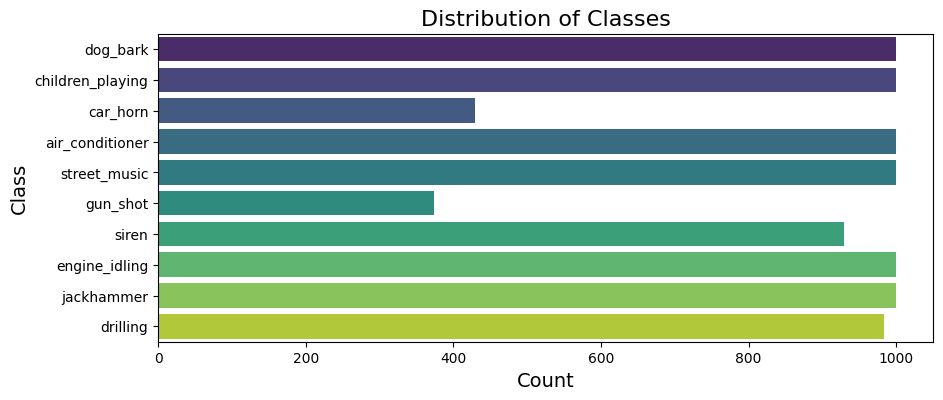

In [ ]:
plt.figure(figsize = (10, 4))
sns.countplot(y = data['class'], palette = 'viridis')
plt.title('Distribution of Classes', fontsize = 16)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Class', fontsize = 14)
plt.show()

In [ ]:
# Displaying a random waveform and spectrogram

# Randomly selecting a row
row = data.sample(1).iloc[0]

# Constructing file path
audioFile = os.path.join(audioPath, 'fold' + str(row['fold']), row['slice_file_name'])

# Loading audio file
waveform, sampleRate = librosa.load(audioFile)

# Displaying audio
print(f"Class : {row['class']}\n")
ipd.display(ipd.Audio(waveform, rate = sampleRate))

# Displaying waveform
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.plot(waveform)
plt.title('Waveform', fontsize = 16)
plt.xlabel('Sample Index', fontsize = 12)
plt.ylabel('Amplitude', fontsize = 12)

# Displaying spectrogram
plt.subplot(1, 2, 2)
plt.specgram(waveform, Fs = sampleRate)
plt.title('Spectrogram', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Frequency (Hz)', fontsize = 12)

plt.show()

In [ ]:
def augmentData(waveform):
    # Applying pre-emphasis
    waveform = librosa.effects.preemphasis(waveform)

    # Time stretching
    if np.random.rand() < 0.5:
        rate = np.random.uniform(0.8, 1.2)
        waveform = librosa.effects.time_stretch(waveform, rate = rate)

    # Adding noise
    waveform += 0.01 * np.random.normal(size = waveform.shape)

    return waveform

In [ ]:
def mfccExtract(file):
    # Loading audio file
    waveform, sampleRate = librosa.load(file)

    # waveform = augmentData(waveform)
    features = librosa.feature.mfcc(y = waveform, sr = sampleRate, n_mfcc = 64)
    return np.mean(features, axis = 1)

In [ ]:
# Storing mfcc features along with classes in dataframe
extractAll = []

# Iterating through each row
for index, row in tqdm(data.iterrows()):
    # Constructing file path
    audioFile = os.path.join(audioPath, 'fold' + str(row['fold']), row['slice_file_name'])

    # Extracting features and appending them
    features = mfccExtract(audioFile)
    extractAll.append([features, row['class']])

8732it [03:17, 44.17it/s]


In [ ]:
featuresDf = pd.DataFrame(extractAll, columns = ['Features', 'Class'])
featuresDf.head()

,Features,Class
0,"[-211.93698, 62.581207, -122.81315, -60.74528,...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578068, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690277,...",children_playing


In [ ]:
# Converting features into numpy array
x = np.array(featuresDf['Features'].tolist())

# Encoding classes
encoder = LabelEncoder()
y = encoder.fit_transform(featuresDf['Class'])
y = to_categorical(y, num_classes = 10)

In [ ]:
trainX, testX, trainY, testY = train_test_split(x, y, stratify = y, random_state = 0)

In [ ]:
model = Sequential([
    layers.Dense(1024, activation = 'relu', input_shape = (64,)),
    layers.BatchNormalization(),

    layers.Dense(512, activation = 'relu'),
    layers.BatchNormalization(),

    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),

    layers.Dense(128, activation = 'relu'),
    layers.BatchNormalization(),

    layers.Dense(64, activation = 'relu'),
    layers.BatchNormalization(),

    layers.Dense(32, activation = 'relu'),
    layers.BatchNormalization(),

    layers.Dense(10, activation = 'softmax')
])

# Defining optimizer, loss function, and metrics
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              66560     
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_2 (Bat  (None, 256)              

In [ ]:
# Adding early stopping to avoid overfitting
earlyStopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 5e-4,
    patience = 5,
    restore_best_weights = True
)

In [ ]:
# Adding a learning rate annealer
reduceLR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    factor = 0.5,
    patience = 3,
    min_lr = 1e-5
)

In [ ]:
# Training model
history = model.fit(
    trainX, trainY,
    validation_data = (testX, testY),
    epochs = 50,
    callbacks = [earlyStopping, reduceLR]
)

Epoch 1/50


205/205 [==============================] - 7s 13ms/step - loss: 1.4760 - accuracy: 0.5228 - val_loss: 1.1429 - val_accuracy: 0.6482 - lr: 0.0010
Epoch 2/50
205/205 [==============================] - 2s 11ms/step - loss: 1.0075 - accuracy: 0.6775 - val_loss: 0.8865 - val_accuracy: 0.7164 - lr: 0.0010
Epoch 3/50
205/205 [==============================] - 2s 12ms/step - loss: 0.7973 - accuracy: 0.7459 - val_loss: 0.7161 - val_accuracy: 0.7737 - lr: 0.0010
Epoch 4/50
205/205 [==============================] - 2s 12ms/step - loss: 0.6777 - accuracy: 0.7865 - val_loss: 0.8051 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 5/50
205/205 [==============================] - 3s 13ms/step - loss: 0.5975 - accuracy: 0.8033 - val_loss: 0.5223 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 6/50
205/205 [==============================] - 2s 11ms/step - loss: 0.4957 - accuracy: 0.8409 - val_loss: 0.4868 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 7/50
205/205 [==============================] - 3s 14ms/

In [ ]:
historyDf = pd.DataFrame(history.history)

<Axes: >

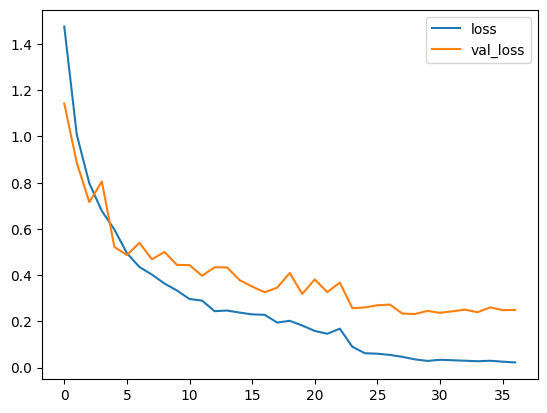

In [ ]:
# Plotting training and validation loss
historyDf.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

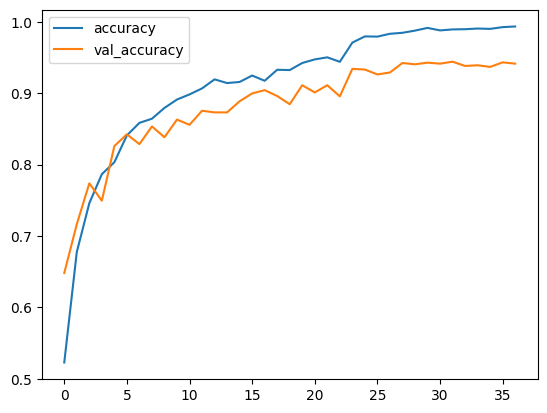

In [ ]:
# Plotting training and validation accuracy
historyDf.loc[:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
# Evaluating model
score = model.evaluate(testX, testY)[1] * 100
print(f'Validation accuracy of model : {score:.2f}%')

69/69 [==============================] - 0s 3ms/step - loss: 0.2439 - accuracy: 0.9441
Validation accuracy of model : 94.41%


69/69 [==============================] - 1s 3ms/step


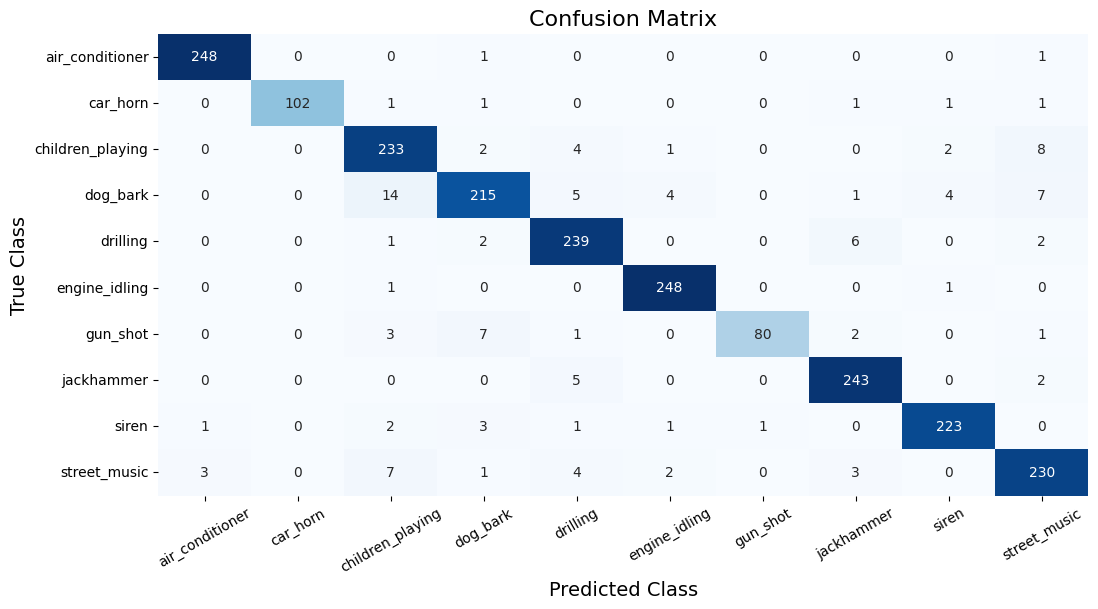

In [ ]:
# Plotting confusion matrix
pred = np.argmax(model.predict(testX), axis = 1)
true = np.argmax(testY, axis = 1)

matrix = confusion_matrix(true, pred)

plt.figure(figsize = (12, 6))
sns.heatmap(matrix, annot = True, cbar = False, fmt = 'd', cmap = 'Blues', xticklabels = encoder.classes_, yticklabels = encoder.classes_)
plt.title('Confusion Matrix', fontsize = 16)
plt.xlabel('Predicted Class', fontsize = 14)
plt.xticks(rotation = 30)
plt.ylabel('True Class', fontsize = 14)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming 'model' is your trained model
#model.save('/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/CNN_nail_classification_model.h5')
model.save('/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/CNN_nail_classification_model.keras')

# AUDIO CLASSIFICATION Testing

##User Interface created using Gradio

In [ ]:
!pip install gradio

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
import gradio as gr

In [ ]:
classes_dict = {
0:'Class_1_-_Tinea_unguium',
1:'Class_2_-_Paronychia',
2:'AppClass_3_-_Ingrown_Toenail',
3:'Class_4_-_Nail_Psoriasis',
4:'Class_5_-_Erythrasma'
}


# Remove underscores from the dictionary values
classes_dict_cleaned = {key: value.replace('_', ' ') for key, value in classes_dict.items()}

# Now, classes_dict_cleaned contains the cleaned class names
print(classes_dict_cleaned)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input

# Function to make predictions
def prediction(path, model, classes_dict):
    """
    This function takes an audio file path, loads a pre-trained model,
    preprocesses the audio, and makes a prediction using the model.

    Parameters:
    - path: The path to the input audio.
    - model: The pre-trained model for classification.
    - classes_dict: A dictionary mapping class indices to human-readable labels.

    Returns:
    - img: The original input audio.
    - predicted_class: The predicted class label.
    """

    # Load and preprocess the audio
    img = load_img(path, target_size=(180, 180))  # Resizing the audio to the model input size
    img_arr = img_to_array(img)                   # Convert audio to array
    processed_img_arr = preprocess_input(img_arr) # Preprocess audio for model compatibility

    # Expand audio dimensions to match the input shape for the model (batch_size, height, width, channels)
    img_exp_dim = np.expand_dims(processed_img_arr, axis=0)

    # Make predictions using the model
    prediction_probabilities = model.predict(img_exp_dim)
    pred_class_index = np.argmax(prediction_probabilities)
    predicted_class = classes_dict[pred_class_index]
    predicted_probability = prediction_probabilities[0][pred_class_index]

    # Display the predicted class and probability
    print(f"Predicted Class: {predicted_class} with probability {predicted_probability:.2f}")

    # Plot the input audio with the prediction
    plt.imshow(img)
    plt.axis('off')  # Remove axis
    plt.title(f"Predicted Class: {predicted_class}")
    plt.show()

    return img, predicted_class

# Function to load the model and perform prediction
def predict(audio):
    """
    This function takes an audio object from the user interface,
    loads a pre-trained model, and makes a prediction.

    Parameters:
    - audio: The audio object passed from the user interface.

    Returns:
    - img: The processed audio.
    - predicted_class: The predicted class label.
    """

    # Load the pre-trained model (ensure the path to your model is correct)
    model = load_model("/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/CNN_nail_classification_model.keras")  # Adjust the path accordingly

    # Extract the file path from the audio object
    path = audio.name

    # Define your class dictionary mapping indices to class names
    print("classes_dict_cleaned : ",classes_dict_cleaned)

    # Call the prediction function
    img, predicted_class = prediction(path, model, classes_dict_cleaned)

    return img, predicted_class

# Main code to call the prediction function
if __name__ == "__main__":
    # Example path to an audio / AUDIO
    audio_path = "/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/Class 2 - Paronychia/frame_0513.jpg"

    # Assuming audio is an object similar to what would be passed by a UI (for testing)
    class audioObject:
        def __init__(self, name):
            self.name = name

    # Create an audio object
    audio = audioObject(audio_path)

    # Call the predict function
    img, predicted_class = predict(audio)

    # Optionally, print the predicted class for logging
    print(f"Final Predicted Class: {predicted_class}")